# Proof of concept

A proof-of-concept of the main "originality score" algorithm: preprocessing a sample paper, performing analytics, saving the document's hash, and returning a score.

In [167]:
import warnings
warnings.filterwarnings('ignore')

import os
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [168]:
print(tf.__version__)

1.9.0


## Read in dataset
Load the [Reuter 50_50 training dataset](https://archive.ics.uci.edu/ml/datasets/Reuter_50_50).

TODO:  download and extract directly from website

In [190]:
# source modified from:
# https://github.com/devanshdalal/Author-Identification-task/blob/master/learner.py
path = 'data/C50/C50train/'
authors = os.listdir(path)
data = []

for author in authors:
  texts = os.listdir(path + author + '/')
  for text in texts:
    f=open(path + author + '/' + text, 'r')
    data.append([author, f.read()])
    f.close()
    
df = pd.DataFrame(data, columns=["author", "text"])
df.head()

# TODO: add more author, text pairs

,author,text
0,RobinSidel,Drugstore giant Revco D.S. Inc. said Monday it...
1,RobinSidel,"Mattel Inc., seeking to expand in the market f..."
2,RobinSidel,A financial agreement between Barney's Inc and...
3,RobinSidel,An independent shareholder advisory firm recom...
4,RobinSidel,Raising the stakes in the escalating battle fo...


## Preprocess data
### Process text

In [208]:
import gensim.downloader as api

# https:/github.com/RaRe-Technologies/gensim-data
# glove-twitter-25
# word2vec-google-news-300
info = api.info()
embed_model = api.load("glove-twitter-100")

# print sample data
print("Embedding for 'house':\n", embed_model.wv['house'])
print("\nSimilar words to 'house':\n", embed_model.most_similar("house"))

Embedding for 'house':
 [-1.3345e-01  3.4688e-01  3.0748e-01 -2.1794e-03  7.1898e-01 -2.8725e-03
  9.5989e-02  5.5276e-01  1.2153e-01 -2.6555e-01 -1.0277e+00  7.2278e-01
 -4.2767e+00 -9.0406e-02  1.1909e-01 -5.0647e-02 -3.3165e-01 -1.8213e-01
 -3.6218e-01  6.9813e-03  2.0147e-01 -2.9150e-01 -1.6417e-01 -2.8022e-01
  5.4800e-01 -5.8081e-01  3.8146e-01 -5.5519e-01  1.6094e-01 -5.2039e-02
 -1.4798e-01  1.0892e-03 -2.6702e-01 -1.7885e-01  5.1449e-02  6.7434e-02
  9.5654e-02  5.6137e-01  7.1208e-03  4.7000e-01 -3.1460e-01  1.0552e+00
  5.2215e-01 -4.8432e-01  2.8615e-01  7.9474e-02  6.4211e-01  6.5274e-01
 -2.6493e-01 -8.9566e-02 -2.6298e-01 -3.4906e-01  3.3645e-02  2.1278e-01
 -1.0738e+00 -3.6867e-01  1.8473e-01  3.3821e-01  5.7516e-01  1.7559e-01
 -1.5436e-01  5.2836e-02 -9.8523e-02 -4.0975e-01 -8.5839e-02 -3.1527e-01
  1.7936e-01 -2.0953e-01  6.6424e-01 -5.7412e-02  2.4528e-01 -2.2577e-01
 -3.3233e-01  2.1225e-01  2.3743e-01  1.3298e-01 -4.4889e-01  4.9577e-01
  4.3360e-01  2.4248e-01  1

In [ ]:
embed_model[w] for w in 

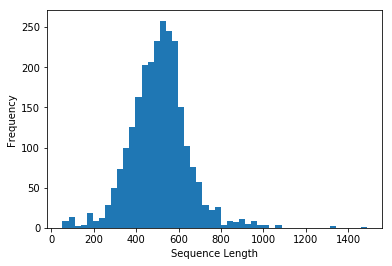

In [191]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
%matplotlib inline

VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')

tokenizer.fit_on_texts(df["text"])
X = tokenizer.texts_to_sequences(df["text"])

# plot histogram 
num_words = [len(n) for n in X]
plt.hist(num_words, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [6]:
import pickle

# Save Tokenizers
with open('data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Process authors

In [192]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
encoded = encoder.fit_transform(df["author"])
y = to_categorical(encoded)

print("Author {} is one-hot encoded as:\n".format(df["author"][0]), y[0])

Author RobinSidel is one-hot encoded as:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [182]:
# Create 100 word chucks
WINDOW_SIZE = 200
WINDOW_SPACING = 100
X_chunks = []
y_chunks = []

def chunk(x, y):
    x_chunk = []
    y_chunk = []
    
    for i in range(0, len(x)-WINDOW_SIZE, WINDOW_SPACING):
        x_chunk.append(x[i:i+WINDOW_SIZE])
        y_chunk.append(y)
    
    return x_chunk, y_chunk

for i, _ in enumerate(X):
    xc, yc = chunk(X[i], y[i])
    X_chunks += xc
    y_chunks += yc

In [183]:
X_chunks = np.array(X_chunks)
y_chunks = np.array(y_chunks)
len(X_chunks)

2118

In [193]:
# Pad sequences, use 500 as maximum length.
X = pad_sequences(X, maxlen=500)

print("Here is the first text tokenized, size {}:\n".format(len(X[0])), X[0])

Here is the first text tokenized, size 500:
 [  203    64     9  1864    10     1    41    27    14   694     8    47
    57 10446  1881   235   203    64   224 10446    80  1297    40   307
    89   272    15  1133   216     4    64     9     1    36   393    80
   250   201  8975    84    42    15   505    40  1487   565   272     5
  1364   180     9  1316    13 10446   112   860  4841  2325     6   462
     6    87  6499    37   115   868  1032   120   933   288   954   764
     6   256   120    87   470   391    72  5156    34  1743    22   579
     1   933    41     2  2096   264    59     4  1432   764     3   861
 17281     7   201   682     7    12    22   311    13  4011     2  1506
     4  3542  1199   234   171    72   528  7482  3754   201   682    24
    46  2640   523    10    25  5157     1  6500  4592     3  1708   719
  2139    70     6   582  2266  1578    12    24    46  1691    16 12794
   123   801     6    87     6    17   156    25  1940   645   558    71
  1099

In [194]:
# Break sequences into chuncks
inv_map = {v: k for k, v in tokenizer.word_index.items()}
for i in [7482, 584, 4011, 2324, 48, 109, 7]:
    print(inv_map[i])

drugstore
giant
revco
d
s
inc
said


## Train Network
### Create training and test sets

In [195]:
from sklearn.model_selection import train_test_split

# Keeps some authors aside for hash testing
x_train, x_new, y_train, y_new = train_test_split(X, y, train_size=0.8, shuffle=False)

# Split remainder into 70% training and 30% testing and shuffle
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.7, random_state=1)

print("New:  {} text from {} authors".format(x_new.shape[0], len(np.unique(y_new, axis=0))))
print("Train: {} text from {} authors".format(x_train.shape[0], len(np.unique(y_train, axis=0))))
print("Test:  {} text from {} authors".format(x_test.shape[0], len(np.unique(y_test, axis=0))))

New:  500 text from 10 authors
Train: 1400 text from 40 authors
Test:  600 text from 40 authors


In [196]:
print("Sample training data, showing authors")
print(np.argmax(y_train, axis=1)[:100])

Sample training data, showing authors
[ 6 39 40 45  3 46 23  3  5  8  1 10 20 41 25 49 21 15 14  7 10 13 28 22
  0 39 20 14 25 22 40  7 35  5 33  8 33 29 35 38  1 28 16 40 15 10 27  9
 23 13  5 46 41 27 10 33  5 40 45  9 10 18 20 45 21 29 45 36 31 41 21  0
 14 18 40 27 12 33 19 41 20  8 23 13  8 27 34 14 16 27 22 16 19 28 16 15
 10 17 16 36]


### Create network model

In [197]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Bidirectional

model = Sequential()
model.add(Embedding(VOCAB_SIZE, 128, mask_zero=True, name='embed'))
#model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, name='lstm')))
#model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=False, name='lstm2')))
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.4, return_sequences=False, name='lstm2'))
model.add(Dense(50, activation='softmax', name='dense'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, None, 128)         2560000   
_________________________________________________________________
lstm2 (LSTM)                 (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 50)                1650      
Total params: 2,582,258
Trainable params: 2,582,258
Non-trainable params: 0
_________________________________________________________________


### Train network

In [199]:
model.fit(x_train, 
          y_train,
          epochs=20,
          validation_split=0.2,
          shuffle=True)

Train on 1120 samples, validate on 280 samples
Epoch 1/20
1120/1120 [==============================] - 21s 19ms/step - loss: 3.6539 - acc: 0.0580 - val_loss: 3.6590 - val_acc: 0.0464
Epoch 2/20
1120/1120 [==============================] - 21s 19ms/step - loss: 3.6392 - acc: 0.0616 - val_loss: 3.6447 - val_acc: 0.0714
Epoch 3/20
1120/1120 [==============================] - 21s 19ms/step - loss: 3.6315 - acc: 0.0634 - val_loss: 3.6283 - val_acc: 0.1464
Epoch 4/20
1120/1120 [==============================] - 22s 19ms/step - loss: 3.6185 - acc: 0.0661 - val_loss: 3.6096 - val_acc: 0.1571
Epoch 5/20
1120/1120 [==============================] - 21s 19ms/step - loss: 3.6079 - acc: 0.0786 - val_loss: 3.5924 - val_acc: 0.1429
Epoch 6/20
1120/1120 [==============================] - 21s 19ms/step - loss: 3.5902 - acc: 0.1054 - val_loss: 3.5738 - val_acc: 0.1464
Epoch 7/20
1120/1120 [==============================] - 21s 19ms/step - loss: 3.5654 - acc: 0.1196 - val_loss: 3.5498 - val_acc: 0.1571
E

In [152]:
MODEL = 'data/1-lstm32-model.h5'
model = keras.models.load_model(MODEL)

### Test network

In [153]:
score, acc = model.evaluate(x_test, y_test)

print('Test score:', score)
print('Test accuracy:', acc)

12134/12134 [==============================] - 9s 737us/step
Test score: 4.292130588247294
Test accuracy: 0.08529751112821841


## Create and compare hashes

In [154]:
from sklearn.metrics.pairwise import cosine_similarity

def get_author(index):
    return encoder.inverse_transform(y_hash[index])

def get_hash(text):
    return model.predict(text)

def get_similarity(hash1, hash2):
    return cosine_similarity(hash1, hash2)

In [155]:
x_hash = get_hash(x_new)
y_hash = [np.argmax(y_hot) for y_hot in y_new]

In [158]:
import warnings
warnings.filterwarnings('ignore')

def print_similarity(i, j):
    similarity = get_similarity([x_hash[i]], [x_hash[j]])
    similarity = float(similarity)
    if get_author(i) == get_author(j):
        print("Comparision of text {} and {} \tfor same author {} is: \t\t".format(
             i, j, get_author(i)), end=' ')
        print("{:0.10f}".format(similarity))
    else:
        print("Comparision of text {} and {} \tfor authors {} and {} is: \t".format(
             i, j, get_author(i), get_author(j)), end=' ')
        print("{:0.10f}".format(similarity))

for i in range(0, 10000, 100):
    print_similarity(0, i)

Comparision of text 0 and 0 	for same author MatthewBunce is: 		 1.0000001192
Comparision of text 0 and 100 	for same author MatthewBunce is: 		 0.2801046968
Comparision of text 0 and 200 	for same author MatthewBunce is: 		 0.1978359669
Comparision of text 0 and 300 	for same author MatthewBunce is: 		 0.3308121264
Comparision of text 0 and 400 	for same author MatthewBunce is: 		 0.0289533120
Comparision of text 0 and 500 	for same author MatthewBunce is: 		 0.1593162715
Comparision of text 0 and 600 	for same author MatthewBunce is: 		 0.0391608477
Comparision of text 0 and 700 	for same author MatthewBunce is: 		 0.0487956963
Comparision of text 0 and 800 	for same author MatthewBunce is: 		 0.2819902301
Comparision of text 0 and 900 	for authors MatthewBunce and ToddNissen is: 	 0.0784679949
Comparision of text 0 and 1000 	for authors MatthewBunce and ToddNissen is: 	 0.0443410091
Comparision of text 0 and 1100 	for authors MatthewBunce and ToddNissen is: 	 0.0389439613
Comparisio

In [149]:
true_positive, true_negative, false_positive, false_negative = 0,0,0,0
margin = 0.2
num_texts = len(x_new)

for i in range(num_texts - 1):
    similarity = get_similarity([x_hash[i]], x_hash)
    
    for j in range(i, num_texts):
        if similarity[0][j] >= margin:
            if y_hash[i] == y_hash[j]:
                true_positive += 1
            else:
                false_positive += 1
        else:
            if y_hash[i] == y_hash[j]:
                false_negative += 1
            else:
                true_negative += 1

print("True positives ", true_positive)
print("False positives", false_positive)
print("True negatives ", true_negative)
print("False negatives", false_negative)

KeyboardInterrupt: 

In [161]:
# Comparison just for the same author
y_new_ints = np.unique(np.argmax(y_new, axis=1))
y_new_authors = encoder.inverse_transform(y_new_ints)
new_authors = {name:{"correct":0, "incorrect":0} for name in y_new_authors}
margin = 0.8

for i in range(num_texts - 1):
    similarity = get_similarity([x_hash[i]], x_hash)
    
    for j in range(i, num_texts):
        if y_hash[i] == y_hash[j]:
            if similarity[0][j] >= margin:
                new_authors[get_author(i)]["correct"] += 1
            else:
                new_authors[get_author(i)]["incorrect"] += 1

print("Number of correctly identified text belonging to each author:")             
new_authors

Number of correctly identified text belonging to each author:


{'AlexanderSmith': {'correct': 15869, 'incorrect': 713159},
 'BernardHickey': {'correct': 8897, 'incorrect': 436199},
 'GrahamEarnshaw': {'correct': 13727, 'incorrect': 519301},
 'KirstinRidley': {'correct': 11192, 'incorrect': 569311},
 'LydiaZajc': {'correct': 5742, 'incorrect': 213710},
 'MatthewBunce': {'correct': 8930, 'incorrect': 326860},
 'PeterHumphrey': {'correct': 30291, 'incorrect': 680737},
 'SarahDavison': {'correct': 16374, 'incorrect': 682779},
 'TimFarrand': {'correct': 9079, 'incorrect': 450282},
 'ToddNissen': {'correct': 16713, 'incorrect': 524607}}

In [162]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=y_new_authors,
    y=[new_authors[d]["correct"] for d in new_authors],
    name='Correct'
)
trace2 = go.Bar(
    x=y_new_authors,
    y=[new_authors[d]["incorrect"] for d in new_authors],
    name='Incorrect'
)

data = [trace1, trace2]
layout = go.Layout(
    title='Hash correctness using Margin={}'.format(margin),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='jupyter-basic_bar')

### Analysis

The chart above shows that the neural network does a great job of identifying the text written by Lydia and Todd and a good job identifying the text from Graham, Matthew, and Peter. For the other authors, it does not perform as well; in two cases (Alexander and Kristin) it is wrong more than it is right. Another issue is the large percentage of false positives when compared to other author texts. While some text from different authors may share certain characteristics, the goal of the algorithm is to maximize their differences.

More work will be coming in two areas: (1) improving the network to have > 80% test accuracy (if possible) and improving the comparison algorithm's ability to differentiate texts.

In [200]:
# save model
model.save("data/3-lstm32-model.h5")

In [207]:
m2 = keras.models.load_model("data/1-lstm32-model.h5")